# Time-dependent shear strength model for corroded RC beams using machine learning

created by De-Cheng Feng and Bo Fu

In [433]:
# define some necessary packages
import os
import numpy as np
import scipy as sp
import pandas as pd

In [434]:
# impoting the strength database
from openpyxl import load_workbook

dataset = pd.read_excel('corr_beam.xlsx', sheet_name='corr_beam')
dataset.head()

,fc,b,h,rho_l,rho_v,fy,fyv,s,lambda_s,eta_l,eta_w,h0,y
0,33.40,254,610,1.90,0.39,441,496,254,2.04,0.00,13.20,521.0,507.0
1,20.93,120,230,2.62,0.56,435,464,150,1.50,0.00,11.73,184.0,129.0
2,20.00,150,180,2.26,0.19,369,332,200,2.20,8.60,5.10,130.0,68.0
3,25.00,150,200,2.30,0.25,210,275,150,2.20,3.14,2.75,166.0,79.0
4,33.10,140,220,1.48,0.90,580,560,80,1.76,0.00,24.31,170.0,90.0


In [435]:
# checking the dimension of the database
print(dataset.shape)

(158, 13)


In [436]:
# reading the original input variables from the database
fc = dataset.loc[:, 'fc']
b = dataset.loc[:, 'b']
h = dataset.loc[:, 'h']
rho_l = dataset.loc[:, 'rho_l']
rho_v = dataset.loc[:, 'rho_v']
fy = dataset.loc[:, 'fy']
fyv = dataset.loc[:, 'fyv']
s = dataset.loc[:, 's']
lambda_s = dataset.loc[:, 'lambda_s']
eta_l = dataset.loc[:, 'eta_l']
eta_w = dataset.loc[:, 'eta_w']
h0 = dataset.loc[:, 'h0']

In [437]:
# constructing 6 new normalized dimensionless input variables
X = np.zeros(shape=(158,6))
X[:, 0] = lambda_s
X[:, 1] = h0/b
X[:, 2] = rho_l * fy / fc
X[:, 3] = rho_v * fyv / fc
X[:, 4] = eta_l
X[:, 5] = eta_w

print(X.shape)

(158, 6)


In [438]:
# defining the output, i.e., the shear strength of the corroded beam
y = dataset.loc [:, 'y']

print(y.shape)

(158,)


In [439]:
# normalizing the whole data sets
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [440]:
# randomly spliting the database into training-testing sets as 70%-30% 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

In [441]:
# building the machine learnning model using GBRT and evaluating it through 10-fold CV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

regr_1 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=2, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, random_state=0, loss='ls')

scores = cross_val_score (regr_1, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 22.556864197388556


In [442]:
# training the model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 

regr_1.fit(X_train, y_train)

# predicting the results
Z1 = regr_1.predict(X_train)
Z2 = regr_1.predict(X_test)

print("GBRT Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)), "MAE:", mean_absolute_error(y_train, Z1))
print("GBRT Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)), "MAE:", mean_absolute_error(y_test, Z2))

GBRT Training R2: 0.9864231483338094 RMSE: 11.08290480400761 MAE: 8.152859603729743
GBRT Testing R2: 0.9553986369604238 RMSE: 19.191396252694407 MAE: 12.840083358363614


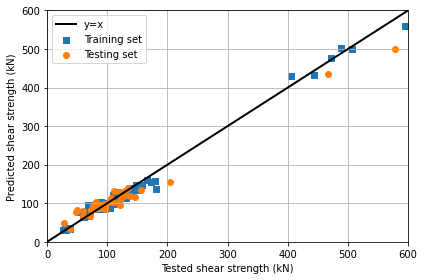

In [443]:
# plotting the scatter for the training and testing sets
import matplotlib.pyplot as plt

xx = np.linspace(0, 600, 100)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested shear strength (kN)')
plt.ylabel('Predicted shear strength (kN)')
plt.xlim([0, 600])
plt.ylim([0, 600])

plt.tight_layout()

In [444]:
# selecting a typical example beam (A1 by Xu and Niu) in 0-100 years time
T = np.arange(0, 110, 10, dtype = float)

fc = 30           # concrete properties
eps0 = 0.002
ft = 2

fy = 400          # steel properties
fu = 650
ff = 200
epsy = 0.002
epsu = 0.12
epsf = 0.16

b0 = 500          # geometric properties, beam width
D0 = 6            # the diameter of reinforcement
PI = 3.1415926
As0 = PI * D0 ** 2 / 4

cover = 30        # concrete cover
n = 4             # number of reinforcement 
psc = 8 ** 2 * PI / 4 * 1260 / ((190 * 440) * 200) # ratio of the volume of corroded transverse reinforcement

In [445]:
# calculating the time begin to corrosion
from scipy.special import erfinv
import math

kt = 0.832
ke = 0.676
kc = 1.0
d0 = 473
t0 = 0.0767
cr = 0.6     
cs = 1.283
age_n = 0.362

Tcorr = (cover ** 2 / (4 * ke * kt * kc * d0 * t0 ** age_n) * erfinv((1 - cr / cs)) ** (-2)) ** (1 / (1 - age_n))
temp = math.ceil(Tcorr / 10)
T = np.insert(T, temp, Tcorr)
ratio_wc = 0.5

In [446]:
# calculating corrosion rate, depth and degree of the beam
r_cr = np.zeros(T.shape, dtype = float, order = 'C')
e_cr = np.zeros(T.shape, dtype = float, order = 'C')
eta_nw = np.zeros(T.shape, dtype = float, order = 'C')
for i in range(T.size):
	if T[i] <= Tcorr:
		r_cr[i] = 0
		e_cr[i] = 0
		eta_nw[i] = 0
	else:
		r_cr[i] = 32.13 * (1 - ratio_wc) ** (-1.64) * (T[i] - Tcorr) ** (-0.29) / cover
		e_cr[i] = 0.5254 * (1 - ratio_wc) ** (-1.64) * (T[i] - Tcorr) ** 0.71 / cover
		eta_nw[i] = (D0 ** 2 - (D0 - 2 * e_cr[i]) ** 2) / D0 ** 2

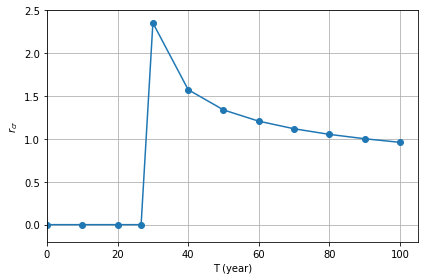

In [447]:
# plotting corrosion rate
plt.xlabel("T (year)") 
plt.ylabel("$r_{cr}$") 
plt.plot(T, r_cr, '-o')

plt.grid()
plt.axis('tight')
plt.xlim([0, 105])
plt.ylim([-0.2, 2.5])

plt.tight_layout()

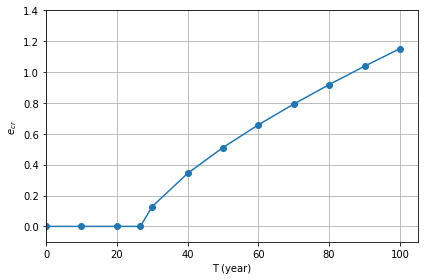

In [448]:
# plotting corrosion depth
plt.xlabel("T (year)") 
plt.ylabel("$e_{cr}$") 
plt.plot(T, e_cr, '-o') 

plt.grid()
plt.axis('tight')
plt.xlim([0, 105])
plt.ylim([-0.1, 1.4])

plt.tight_layout()

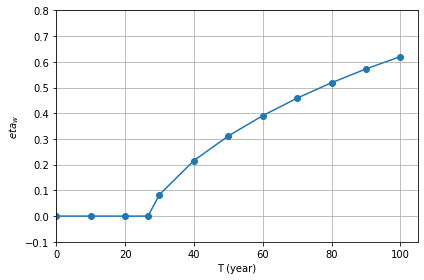

In [449]:
# plotting corrosion degree
plt.xlabel("T (year)") 
plt.ylabel("$eta_{w}$") 
plt.plot(T, eta_nw, '-o') 

plt.grid()
plt.axis('tight')
plt.xlim([0, 105])
plt.ylim([-0.1, 0.8])

plt.tight_layout()

In [453]:
# calculating the time-dependent shear strength of the beam by GBRT model
V_GBRT = np.zeros(T.shape, dtype = float, order = 'C')
for i in range(T.size):
	print(i, eta_nw[i] * 100)
	X = scaler.inverse_transform(X)
	X[125, 5] = eta_nw[i] * 100
	X = scaler.transform(X)
	a = regr_1.predict(X)
	V_GBRT[i] = a [125]

print(T.shape)
print(V_GBRT)

0 0.0
1 0.0
2 0.0
3 0.0
4 8.374631590454346
5 21.583120715619973
6 31.160225035254136
7 39.06311247196651
8 45.87406854598577
9 51.87490580032029
10 57.2312526113455
11 62.051811522232704
(12,)
[117.10733504 117.10733504 117.10733504 117.10733504 116.98901643
 116.89078029 111.73695427 101.76781073 100.59171559  84.52809781
  76.00565193  76.00565193]


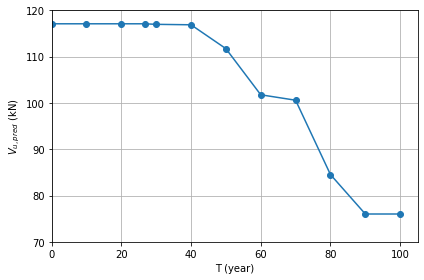

In [454]:
# plotting the time-dependent shear strength of the beam
plt.xlabel("T (year)") 
plt.ylabel('$V_{u,pred}$ (kN)')
plt.plot(T, V_GBRT, '-o')

plt.grid()
plt.axis('tight')
plt.xlim([0, 105])
plt.ylim([70, 120])

plt.tight_layout()